# Data preprocessing

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
from helpers import *
from datetime import datetime, timedelta, date
import pandas as pd

demo = True
if demo:
    Countries_indexes = ["EWS"]
else:
    Countries_indexes = ["EUSA", "EWC", "EWU", "EWG", "EWQ", "EWJ", "MCHI", "INDA", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EWK", "EDEN", "EFNL", "EIS", "EWZ"]

In [2]:
assets_data = get_raw_data(range(2009,2013), Countries_indexes)

Processing yearly tar: Data/ETFs/ETFs-2009.tar
Processing inner tar: ./EWS.P_bbo_2009.tar
Combined DataFrame for ./EWS.P_bbo now has 7599932 rows.
Processing inner tar: ./EWS.P_trade_2009.tar
Skipping non-price file type: ./EWS.P_trade_2009.tar
Processing yearly tar: Data/ETFs/ETFs-2010.tar
Processing inner tar: ./EWS.P_bbo_2010.tar
Combined DataFrame for ./EWS.P_bbo now has 19399668 rows.
Processing inner tar: ./EWS.P_trade_2010.tar
Skipping non-price file type: ./EWS.P_trade_2010.tar
Processing yearly tar: Data/ETFs/ETFs-2011.tar
Processing inner tar: ./EWS.P_bbo_2011.tar
Combined DataFrame for ./EWS.P_bbo now has 33512377 rows.
Processing inner tar: ./EWS.P_trade_2011.tar
Skipping non-price file type: ./EWS.P_trade_2011.tar
Processing yearly tar: Data/ETFs/ETFs-2012.tar
Processing inner tar: ./EWS.P_bbo_2012.tar
Combined DataFrame for ./EWS.P_bbo now has 38469487 rows.
Processing inner tar: ./EWS.P_trade_2012.tar
Skipping non-price file type: ./EWS.P_trade_2012.tar


In [3]:
bucketed_data = get_buckets(assets_data)

c:\Users\marco\Documents\ThirdSemesterCode\FinancialBigData\Project\helpers.py:91: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  (result["time-bucket"].map_elements(lambda x: datetime.utcfromtimestamp(x))),


In [4]:
clean_data = remove_outliers(bucketed_data)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


Example of pre and post outlier removal for EWS

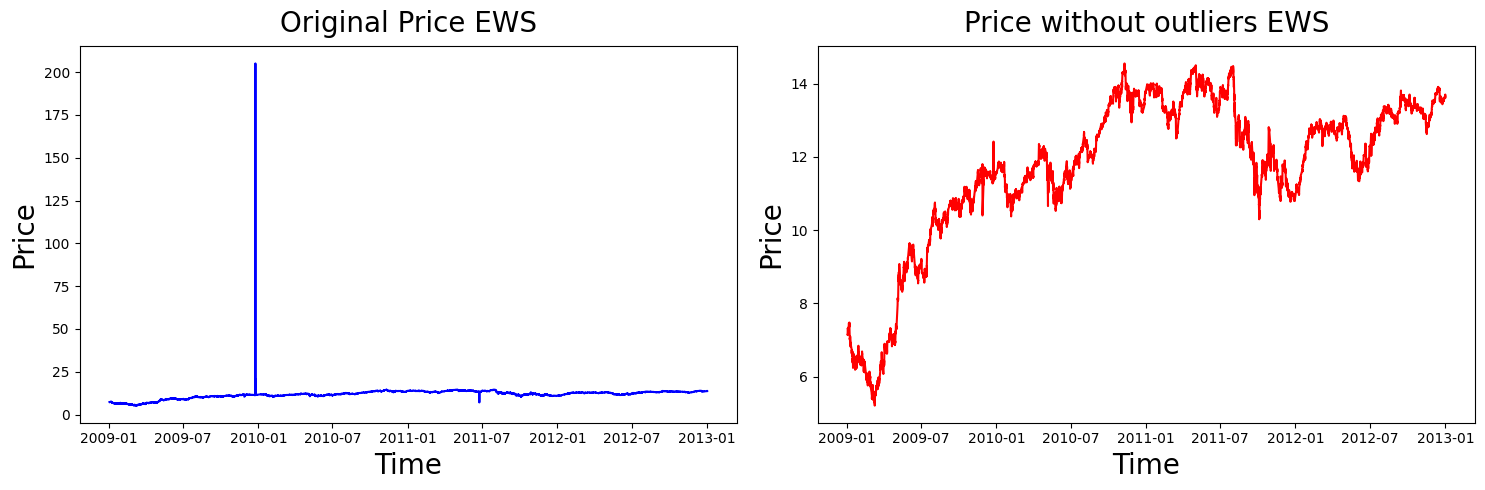

In [5]:
df, cleaned_df = bucketed_data["EWS"], clean_data["EWS"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the original data
ax1.plot(df['time-bucket'], df['weighted-avg-price'], color='b')
ax1.set_title(f'Original Price EWS', va='bottom', fontdict={'fontsize': 20})
ax1.set_xlabel('Time', fontdict={'fontsize': 20})
ax1.set_ylabel('Price', fontdict={'fontsize': 20})

# Plot the cleaned data
ax2.plot(cleaned_df['time-bucket'], cleaned_df['weighted-avg-price'], color='r')
ax2.set_title(f'Price without outliers EWS', va='bottom', fontdict={'fontsize': 20})
ax2.set_xlabel('Time', fontdict={'fontsize': 20})
ax2.set_ylabel('Price', fontdict={'fontsize': 20})

plt.tight_layout()
plt.show()

Now we can save the clean data (if in demo, use the already processed data)

In [6]:
# save_folder = "Data/clean/"

# for key in clean_data.keys():
#     clean_data[key].write_parquet(f"{save_folder}{key}.parquet")

# Extreme mid-price jumps

In [7]:
asset_data = get_raw_data(years = range(2007, 2013, 1) ,asset_names = ["EWO"], print_log=False)

Text(0.5, 1.0, 'EWO ask price')

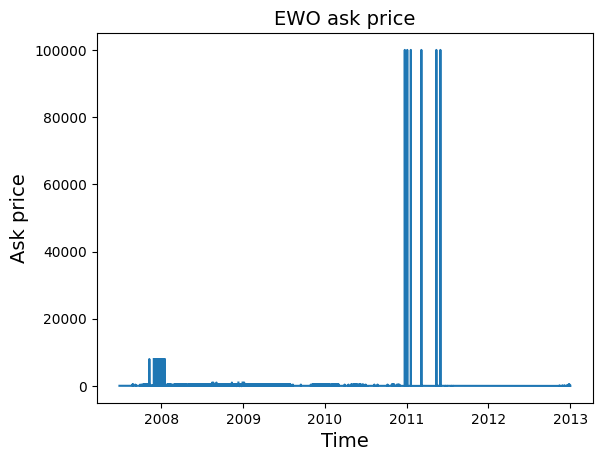

In [8]:
# plotting the ask price of EWO in time. We observe very extreme values in the ask price.
plt.plot(asset_data["EWO"]["datetime"],asset_data["EWO"]["ask-price"])
plt.xlabel("Time", fontdict={"size": 14})
plt.ylabel("Ask price", fontdict={"size": 14})
plt.title("EWO ask price", fontdict={"size": 14})

In [9]:
# Showing a sample of the jumps in the data
temp = asset_data["EWO"].filter(  
                                (pl.col("datetime").dt.date() == date(2007,8,24)) & (pl.col("datetime").dt.hour() == 13))
 
for row in temp.iter_rows(named=True):
    print(row)


{'bid-price': 36.76, 'bid-volume': 20, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 0, 565000, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 86, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 0, 993000, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 106, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 1, 392000, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 24, 'ask-price': 36.85, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 6, 39999, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.75, 'bid-volume': 24, 'ask-price': 36.95, 'ask-volume': 1, 'datetime': datetime.datetime(2007, 8, 24, 13, 0, 25, 307999, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))}
{'bid-price': 36.77, 'bid-volume': 5, 'ask-price': 36.95, '

# Average Difference plot

This is how we get average difference of times between one observation and the previous one 

In [10]:
average_diff_seconds = get_average_diffs(assets_data)

Average time difference for EWS: 0:00:03.278072


For the demo version we get the average difference of only one asset, don't save this and load the already computed one

In [11]:
### Save the average_diff_seconds to a csv file ##
# 
# 
#  data = []
# for ticker in Countries_indexes:
#     if ticker in average_diff_seconds:
#         seconds_val = average_diff_seconds[ticker].total_seconds()  
#         data.append((ticker, seconds_val))

# df = pd.DataFrame(data, columns=["Ticker", "Total_Seconds"])

# df.to_csv("Data/average_diffs_seconds.csv", index=False)

Load data

In [12]:
average_diff_seconds = pd.read_csv("Data/average_diffs_seconds.csv")

In [13]:
average_diff_seconds_clean = average_diff_seconds[~((average_diff_seconds['Ticker'] == "EDEN")| (average_diff_seconds['Ticker'] == "INDA")| (average_diff_seconds['Ticker'] == "EFNL"))]

We plotted also the average seconds without some tickers to make the plot more readable

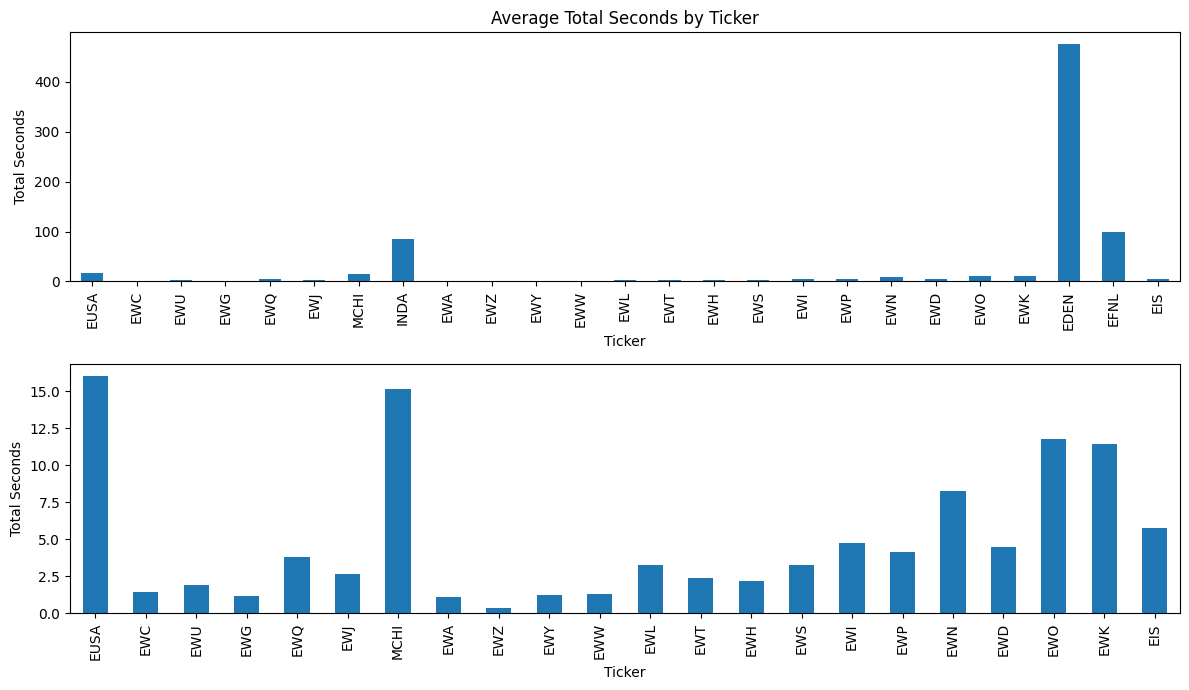

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# First subplot: Average Total Seconds by Ticker
average_diff_seconds.plot(x='Ticker', y='Total_Seconds', kind='bar', ax=axs[0], legend=False)
axs[0].set_title('Average Total Seconds by Ticker')
axs[0].set_xlabel('Ticker')
axs[0].set_ylabel('Total Seconds')
axs[0].tick_params(axis='x', rotation=90)

# Second subplot: Price without outliers
average_diff_seconds_clean.plot(x='Ticker', y='Total_Seconds', kind='bar', ax=axs[1], legend=False)

axs[1].set_xlabel('Ticker')
axs[1].set_ylabel('Total Seconds')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## Epps Effect

In [ ]:
import numpy as np

def plot_epps_effect(asset_1, asset_2, save_address = None, percentile = None):
    # read from clean data into polars

    asset_1_df = pl.read_parquet(f"Data/clean/{asset_1}.parquet")
    asset_2_df = pl.read_parquet(f"Data/clean/{asset_2}.parquet")

    asset_1_df = asset_1_df.with_columns(asset_1_df["weighted-avg-price"].alias(f"price_{asset_1}"))
    asset_2_df = asset_2_df.with_columns(asset_2_df["weighted-avg-price"].alias(f"price_{asset_2}"))

    asset_1_df.drop_in_place("weighted-avg-price")
    asset_2_df.drop_in_place("weighted-avg-price")

    merged = asset_1_df.join(asset_2_df, on="time-bucket", how="inner")

    if percentile:
        merged = merged.to_pandas()
        thresholds = merged.drop(columns = ["time-bucket"]).abs().quantile(percentile / 100)
        merged = merged.apply(lambda col: col.where(col.abs() <= thresholds[col.name]) if col.name != "time-bucket"else col)
        merged = merged.dropna()
        merged = pl.DataFrame(merged)
    
    delta_t = np.arange(1, 1000, 1)
    correlations = []
    for t in tqdm(delta_t):
        rows_to_keep = np.arange(0, merged.height, t)
        temp = merged[rows_to_keep]
        # calculate returns for price columns
        temp = temp.with_columns(
            (temp[f"price_{asset_1}"] / temp[f"price_{asset_1}"].shift(1) - 1).alias(f"return_{asset_1}"),
            (temp[f"price_{asset_2}"] / temp[f"price_{asset_2}"].shift(1) - 1).alias(f"return_{asset_2}")
        )
        # calculate correlation
        correlation = temp.select(pl.corr(f"return_{asset_1}", f"return_{asset_2}")).item(0, 0)
        correlations.append(correlation)
    delta_t *= 5  # 5 seconds per row
    
    plt.scatter(list(delta_t), correlations)
    plt.xlabel(r"$\Delta t$ seconds", fontdict={"size": 14})

    plt.ylabel("Correlation", fontdict={"size": 14})
    plt.title(f"Epps Effect for {asset_1} and {asset_2}", fontdict={"size": 16})
    if save_address:
        plt.savefig(save_address)

100%|██████████| 999/999 [00:02<00:00, 447.60it/s]


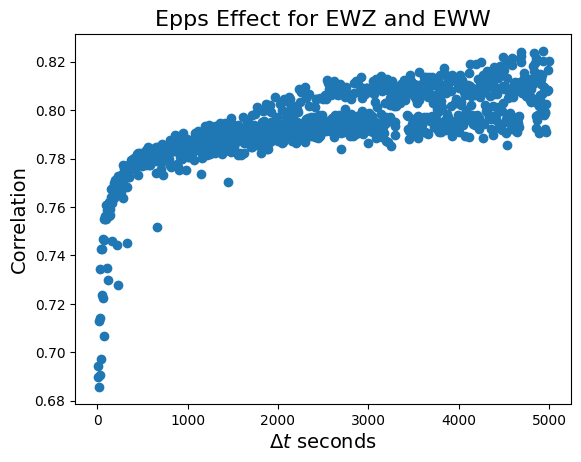

In [ ]:
plot_epps_effect("EWZ", "EWW", "EWZ_EWY_epps.png")

100%|██████████| 999/999 [00:02<00:00, 402.66it/s]


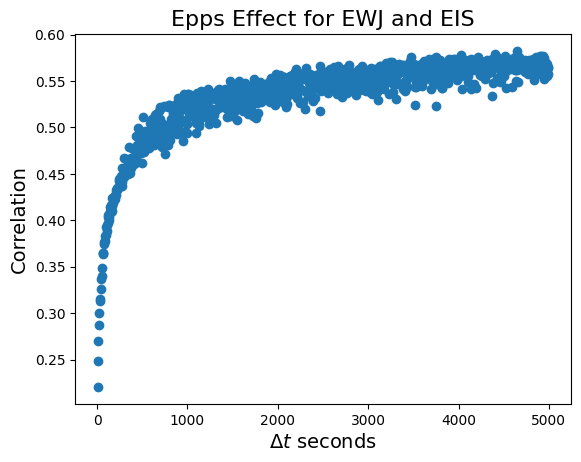

In [ ]:
plot_epps_effect("EWJ", "EIS", "EWJ_EIS_epps.png")

100%|██████████| 999/999 [00:02<00:00, 455.35it/s]


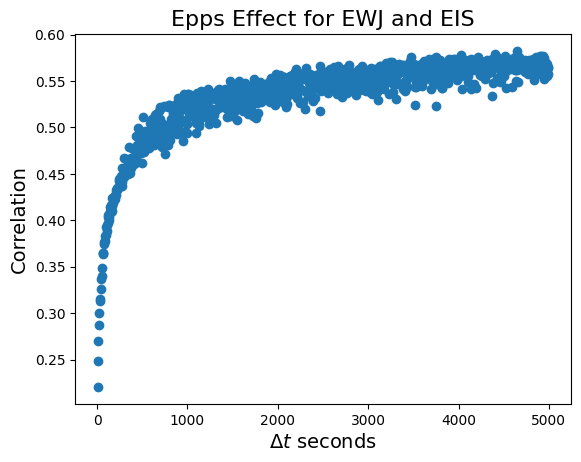

In [ ]:
plot_epps_effect("EWJ", "EIS", "EWJ_EIS_epps.png")

100%|██████████| 999/999 [00:02<00:00, 422.89it/s]


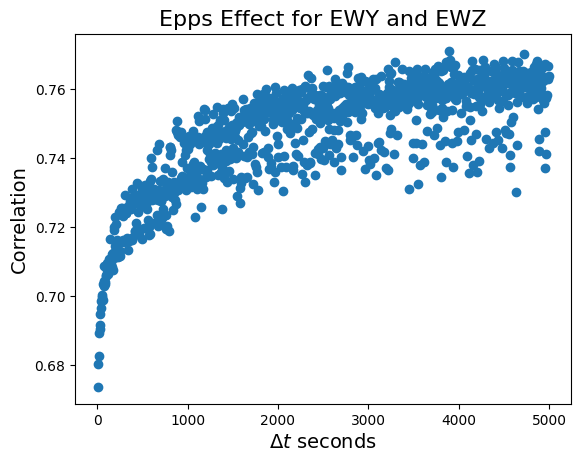

In [ ]:
plot_epps_effect("EWY", "EWZ", "EWY_EWZ_epps_99.png", percentile=99)

100%|██████████| 999/999 [00:02<00:00, 423.85it/s]


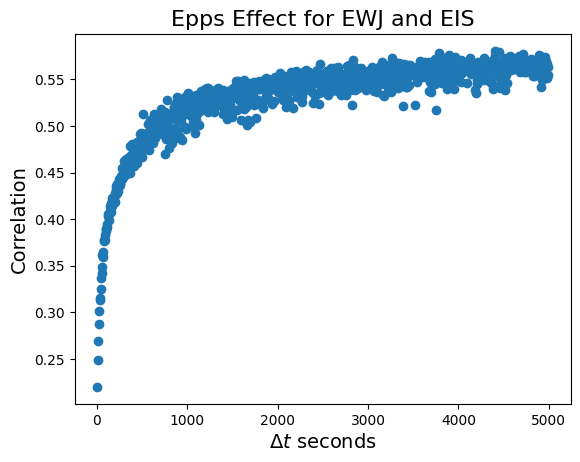

In [ ]:
plot_epps_effect("EWJ", "EIS", "EWJ_EIS_epps_99.png", percentile=99)

100%|██████████| 999/999 [00:02<00:00, 428.62it/s]


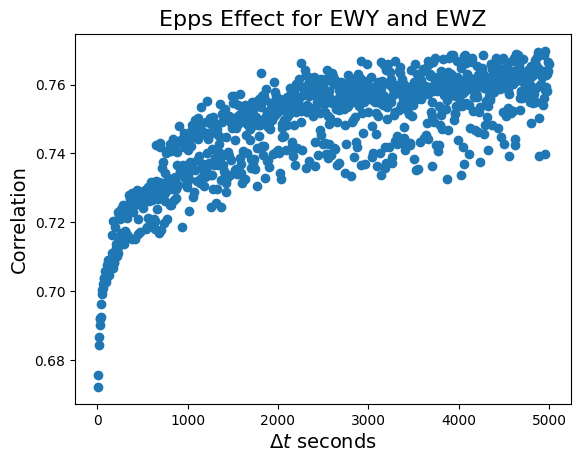

In [ ]:
plot_epps_effect("EWY", "EWZ", "EWY_EWZ_epps_95.png", percentile=95)

100%|██████████| 999/999 [00:02<00:00, 441.77it/s]


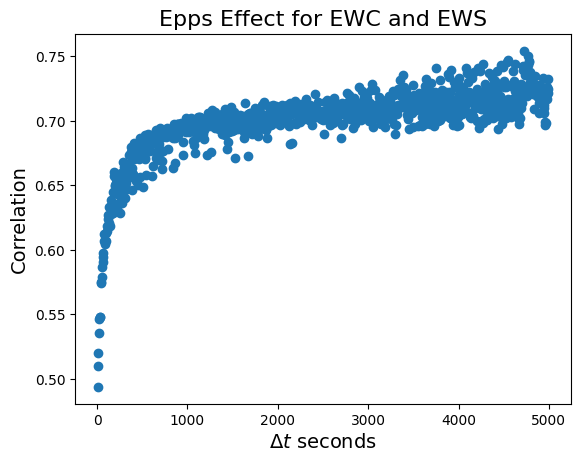

In [ ]:
plot_epps_effect("EWC", "EWS", "EWC_EWS_epps_95.png", percentile=95)

# Compute covariance pairs

Assuming you have a folder of all the cleaned data under Data/clean/...

In [18]:
if demo:
    Countries_indexes = ["EWO", "EWG", "EWS"]
else:
    Countries_indexes = [ "EWC", "EWU", "EWG", "EWQ", "EWJ", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EIS", "EWZ"] 

In [19]:
final_df =  pl.read_parquet(f"Data/clean/{Countries_indexes[0]}.parquet")
print(f"Data for {Countries_indexes[0]}")
for country in Countries_indexes[1:]:
    df = pl.read_parquet(f"Data/clean/{country}.parquet")
    print(f"Data for {country}")
    final_df = final_df.join(df, on="time-bucket", how="inner", suffix=f"_{country}")
final_df = final_df.rename({"weighted-avg-price": f"weighted-avg-price_{Countries_indexes[0]}"})

Data for EWG
Data for EWS


In [20]:
def compute_returns(df, countries, lag=1):
    price_col="weighted-avg-price"
    for country in countries:
        df = df.with_columns(
        (pl.col(f"{price_col}_{country}").diff(lag) / pl.col(f"{price_col}_{country}").shift(lag)).alias(f"return_{country}")
    ).drop_nulls(subset=[f"return_{country}"]).drop(f"{price_col}_{country}")
    return df

In [21]:
final_df = compute_returns(final_df, Countries_indexes)

In [22]:
covs = final_df.group_by_dynamic(index_column="time-bucket", every="25s", period="5m").agg([pl.cov(f"return_{x}", f"return_{y}").alias(f"{x}_{y}") for x in Countries_indexes for y in Countries_indexes])

In [23]:
covs = covs.filter( ~((pl.col("time-bucket").dt.hour() == 15) & (pl.col("time-bucket").dt.minute() > 24)))

Save in the covariance/ folder, if running demo don't save this, use the provided full covs_matrix.parquet

In [ ]:
# covs.write_parquet("covariance/covs_matrix.parquet")

# MVE portfolios

In [24]:
data = pl.read_parquet("covariance/covs_matrix.parquet")

data = data.filter( ~((pl.col("time-bucket").dt.hour() == 15) & (pl.col("time-bucket").dt.minute() > 24)))

In [25]:

def cov_matrix(covs_row: pl.Series, Countries_indexes: list, suffix = ""):
    '''
    Takes as input a row of the covs matrix and the indexes of the countries and returns the Covariance matrix based on that row.
    '''
    cov = np.zeros((len(Countries_indexes), len(Countries_indexes)))
    for i in range(len(Countries_indexes)):
        for j in range(i,len(Countries_indexes)):
            cov[i,j] = cov[j,i] = covs_row[f"{Countries_indexes[i]}_{Countries_indexes[j]}" + suffix][0]
    return cov

Countries_indexes = ["EWC", "EWU", "EWG", "EWQ", "EWJ", "EWA", "EWY", "EWW", "EWL", "EWT", "EWH", "EWS", "EWI", "EWP", "EWN", "EWD", "EWO", "EIS", "EWZ"]

In [26]:
def eigenvalue_clipping(lambdas,v,lambda_plus, print_log=False):
    N=len(lambdas)
    
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    
    lambdas_clean=lambdas.copy()
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
        
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    
    for i in range(N):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 

    if print_log:
        print("Size of the bulk",N_bulk)
        print("Percentage of the bulk",sum_lambda_bulk/sum(lambdas))      
        print(lambdas_clean)
  


    return C_clean


In [27]:
def mvp_weights(covariance_marix):
    try:
        w = np.linalg.inv(covariance_marix).sum(axis=1) / np.linalg.inv(covariance_marix).sum()
    except np.linalg.LinAlgError:
        return None
    return w

# we calculate the optimal weights using the estimated covariance matrix, by either clipping or naive estimation.
# Then we calculate the in-sample/out-of-sample risk using the optimal weights and the current/future true covariance matrix.
def risk_calculation(cov1, cov2):
    weights = mvp_weights(cov1)
    if weights is None:
        return None
    risk = np.dot(weights.T, np.dot(cov2, weights))
    return risk.item()


In [28]:
n = 12

data_shifted = data.with_columns([
    data[col].shift(-n).alias(f"{col}_{n}") for col in data.columns
])

column_names = data_shifted.columns

# drop last n rows
data_shifted = data_shifted.slice(0, -n)

In [29]:
def RIEcov(l_e, V_e, alpha = 0.2):
    RIE_eig = (1 - alpha) * l_e + alpha
    RIE_cov = V_e @ np.diag(RIE_eig) @ V_e.T
    return RIE_cov  

In [ ]:
def row_in_sample_out_sample(row: pl.Series):
    # Get the covariance matrix from the row

    cov_1 = cov_matrix(row, Countries_indexes)
    cov_2 = cov_matrix(row, Countries_indexes, f"_{n}")
    
    l_e, V_e = np.linalg.eig(cov_1)
    mean_variance = np.mean(np.diag(cov_1))
    
    # Define parameters
    N = len(Countries_indexes)
    T = 60
    q = N / T
    lambda_plus = (1 + np.sqrt(q))**2 * mean_variance

    cov_clipped = eigenvalue_clipping(l_e, V_e, lambda_plus)
    cov_RIE = RIEcov(l_e, V_e, 0.4)
    

    # In-sample risk
    
    in_sample_risk_mvp = risk_calculation(cov_1, cov_1)
    in_sample_risk_RIE = risk_calculation(cov_RIE, cov_1)
    in_sample_risk_clip = risk_calculation(cov_clipped, cov_1)


    # Out of sample risk
    out_sample_risk_mvp = risk_calculation(cov_1, cov_2)
    out_sample_risk_RIE = risk_calculation(cov_RIE, cov_2)
    out_sample_risk_clip = risk_calculation(cov_clipped, cov_2)

    in_sample_risk_RIE = None if isinstance(in_sample_risk_RIE, complex) else in_sample_risk_RIE
    in_sample_risk_mvp = None if isinstance(in_sample_risk_mvp, complex) else in_sample_risk_mvp
    in_sample_risk_clip = None if isinstance(in_sample_risk_clip, complex) else in_sample_risk_clip
    out_sample_risk_RIE = None if isinstance(out_sample_risk_RIE, complex) else out_sample_risk_RIE
    out_sample_risk_mvp = None if isinstance(out_sample_risk_mvp, complex) else out_sample_risk_mvp
    out_sample_risk_clip = None if isinstance(out_sample_risk_clip, complex) else out_sample_risk_clip
    # Handle potential complex values in risk
    return out_sample_risk_RIE, out_sample_risk_mvp, out_sample_risk_clip, in_sample_risk_RIE, in_sample_risk_mvp, in_sample_risk_clip



out_sample_risks_RIE = []
out_sample_risks_mvp = []
out_sample_risks_clip = []
in_sample_risks_RIE = []
in_sample_risks_mvp = []
in_sample_risks_clip = []


if demo:
    num_rows = 5000 # set this to at least 10000 to get the same plots as in the report
else:
    num_rows = len(data_shifted)-1

for i in tqdm(range(num_rows)):
    out_sample_risk_RIE, out_sample_risk_mvp, out_sample_risk_clip, in_sample_risk_RIE, in_sample_risk_mvp, in_sample_risk_clip  = row_in_sample_out_sample(data_shifted[i])
    
    in_sample_risks_RIE.append(in_sample_risk_RIE)
    in_sample_risks_mvp.append(in_sample_risk_mvp)
    in_sample_risks_clip.append(in_sample_risk_clip)
    
    
    out_sample_risks_RIE.append(out_sample_risk_RIE)
    out_sample_risks_mvp.append(out_sample_risk_mvp)
    out_sample_risks_clip.append(out_sample_risk_clip)


risks = pl.DataFrame({
    "in_sample_RIE": in_sample_risks_RIE,
    "in_sample_mvp": in_sample_risks_mvp,
    "in_sample_clip": in_sample_risks_clip,
    "out_sample_RIE": out_sample_risks_RIE,
    "out_sample_mvp": out_sample_risks_mvp,
    "out_sample_clip": out_sample_risks_clip,
})

risks_filled = risks.with_columns(
    [   
        pl.col("in_sample_RIE").fill_null(strategy="forward").alias("in_sample_RIE"),
        pl.col("in_sample_mvp").fill_null(strategy="forward").alias("in_sample_mvp"),
        pl.col("in_sample_clip").fill_null(strategy="forward").alias("in_sample_clip"),
        pl.col("out_sample_RIE").fill_null(strategy="forward").alias("out_sample_RIE"),
        pl.col("out_sample_mvp").fill_null(strategy="forward").alias("out_sample_mvp"),
        pl.col("out_sample_clip").fill_null(strategy="forward").alias("out_sample_clip"),
    ]
)
print(f"Mean in-sample risk Naive: {risks_filled['in_sample_mvp'].mean()}, Mean in-sample risk Clip: {risks_filled['in_sample_clip'].mean()}, Mean in-sample risk RIE: {risks_filled['in_sample_RIE'].mean()}")
print(f"Mean out-sample risk Naive: {risks_filled['out_sample_mvp'].mean()}, Mean out-sample risk Clip: {risks_filled['out_sample_clip'].mean()}, Mean out-sample risk RIE: {risks_filled['out_sample_RIE'].mean()}")

100%|██████████| 5000/5000 [01:19<00:00, 63.22it/s] 

Mean in-sample risk Naive: 1.1786341281794955e-09, Mean in-sample risk Clip: 1.309307874041683e-07, Mean in-sample risk RIE: 1.2577655692821818e-07
Mean out-sample risk Naive: 4.3769587466585834e-07, Mean out-sample risk Clip: 2.5737316927324355e-07, Mean out-sample risk RIE: 2.5775999679376446e-07


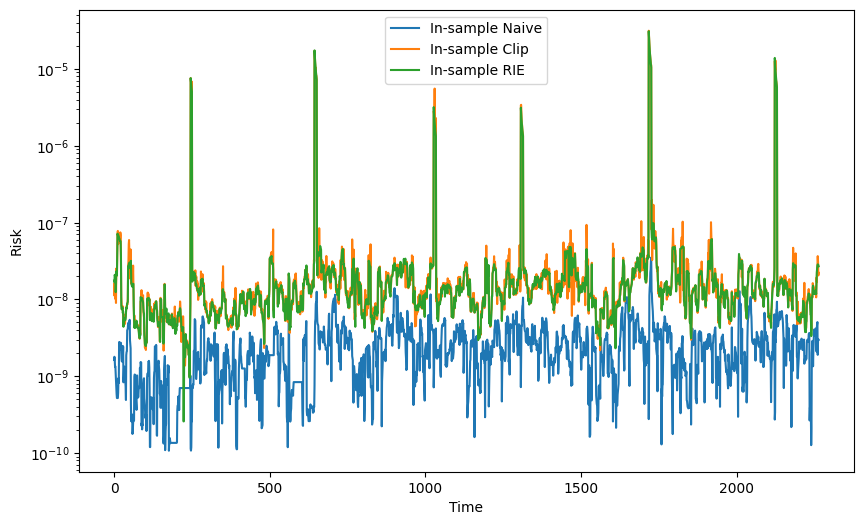

In [31]:
num_to_visualize = 10000

risks_filled_plot = risks_filled.filter(pl.col("in_sample_mvp") > 1e-10) #For better visualization

plt.figure(figsize=(10, 6))
plt.plot(risks_filled_plot["in_sample_mvp"][: min(num_to_visualize, num_rows)], label="In-sample Naive")
plt.plot(risks_filled_plot["in_sample_clip"][: min(num_to_visualize, num_rows)], label="In-sample Clip")
plt.plot(risks_filled_plot["in_sample_RIE"][: min(num_to_visualize, num_rows)], label="In-sample RIE")
plt.ylabel("Risk")
plt.xlabel("Time")
plt.legend()
plt.yscale("log")
plt.show()

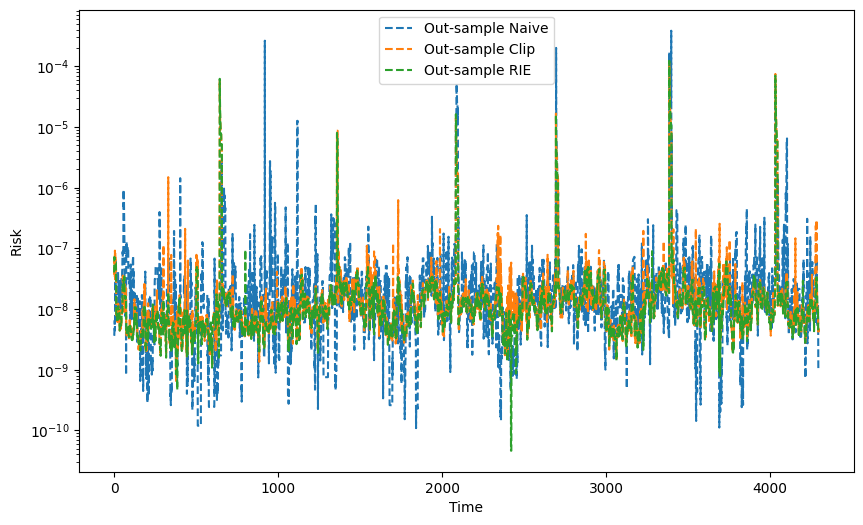

In [32]:
risks_filled_out = risks_filled.filter(pl.col("out_sample_mvp") > 1e-10)
plt.figure(figsize=(10, 6))
plt.plot(risks_filled_out["out_sample_mvp"][: min(num_to_visualize, num_rows)], label="Out-sample Naive", linestyle="--")
plt.plot(risks_filled_out["out_sample_clip"][: min(num_to_visualize, num_rows)], label="Out-sample Clip", linestyle="--")
plt.plot(risks_filled_out["out_sample_RIE"][: min(num_to_visualize, num_rows)], label="Out-sample RIE", linestyle="--")
plt.ylabel("Risk")
plt.xlabel("Time")
plt.legend()
plt.yscale("log")
plt.show()